In [1]:
# Install required modules
#!pip install geopandas numpy pandas matplotlib seaborn shapely pyproj netCDF4 scikit-learn
# Install all necessary modules before importing them
# Run within the Jupyter Notebook system or ensure these modules are installed
import geopandas as gpd
print(gpd.__version__)

1.0.1


In [2]:
# Import all functions from the required modules
from cordo_sherpa_module import *
from cordo_ineris_module import *
from correction_module import *
from expo_functions_module import *
from mortality_analysis_module import *
from plot_module import *

print("Successfully loaded all modules")

loaded defined RR values
Successfully loaded mean conc command
Successfully loaded plotting command
Successfully loaded all modules


In [3]:
# Define paths for shapefiles
path_fichier_shp = "data/2-output-data/donnees_shp"
path_fichier_shp_1 = "data/2-output-data/donnees_shp_1"
path_fichier_shp_2 = "data/2-output-data/donnees_shp_2"
path_fichier_shp_3 = "data/2-output-data/donnees_shp_3"
path_fichier_pourcents = "data/2-output-data"

# Titles for INSEE Data
title_shp = "donnees_insee_iris"
title_shp_1 = "donnees_insee_iris_toutage_1"
title_shp_2 = "donnees_insee_iris_toutage_2"
title_shp_3 = "donnees_insee_iris_toutage_3"
title_pourcents = "pourcents"

# Read shapefiles into GeoDataFrames
donnees_shp = gpd.read_file(os.path.join(path_fichier_shp, f"{title_shp}.shp"))
donnees_shp_1 = gpd.read_file(os.path.join(path_fichier_shp_1, f"{title_shp_1}.shp"))
donnees_shp_2 = gpd.read_file(os.path.join(path_fichier_shp_2, f"{title_shp_2}.shp"))
donnees_shp_3 = gpd.read_file(os.path.join(path_fichier_shp_3, f"{title_shp_3}.shp"))

# Combine the three GeoDataFrames
donnees_merged = gpd.GeoDataFrame(pd.concat([donnees_shp_1, donnees_shp_2, donnees_shp_3], ignore_index=True))

In [4]:
# Dynamically read your shapefile (GeoDataFrame with 'iriscod' and 'geometry')
# Define sc, pol, and year variables
sc = "s1"  # Scenario
pol = "ug_PM25_RH50"  # Pollutant
year = "2030"  # Year

# Construct the shapefile path
shapefile_path = os.path.join("data", "2-output-data", sc, pol, year, "donnees_expo.shp")
donnees_expo = gpd.read_file(shapefile_path)

# Check for NA values in the GeoDataFrame
if donnees_expo.isna().any().any():
    print("Warning: NA values detected in donnees_expo GeoDataFrame.")
else:
    print("No NA values found in donnees_expo GeoDataFrame.")

# Ensure CRS alignment between donnees_merged, donnees_expo, and donnees_shp
if donnees_merged.crs != donnees_shp.crs:
    print(f"Aligning CRS of donnees_merged to match donnees_shp. Original CRS: {donnees_merged.crs}")
    donnees_merged = donnees_merged.to_crs(donnees_shp.crs)

if donnees_expo.crs != donnees_shp.crs:
    print(f"Aligning CRS of donnees_expo to match donnees_shp. Original CRS: {donnees_expo.crs}")
    donnees_expo = donnees_expo.to_crs(donnees_shp.crs)

No NA values found in donnees_expo GeoDataFrame.
Aligning CRS of donnees_expo to match donnees_shp. Original CRS: EPSG:4326


In [5]:
# Step 1: Run your mortality function (age-specific vs without age)
results = calculate_iris_level_mortality_age_specific(donnees_merged, donnees_expo, 2030, "ug_PM25_RH50")

# Step 2: Read your shapefile (GeoDataFrame with 'iriscod' and 'geometry')
iris_shapefile = gpd.read_file("data/2-output-data/donnees_shp/donnees_insee_iris.shp")


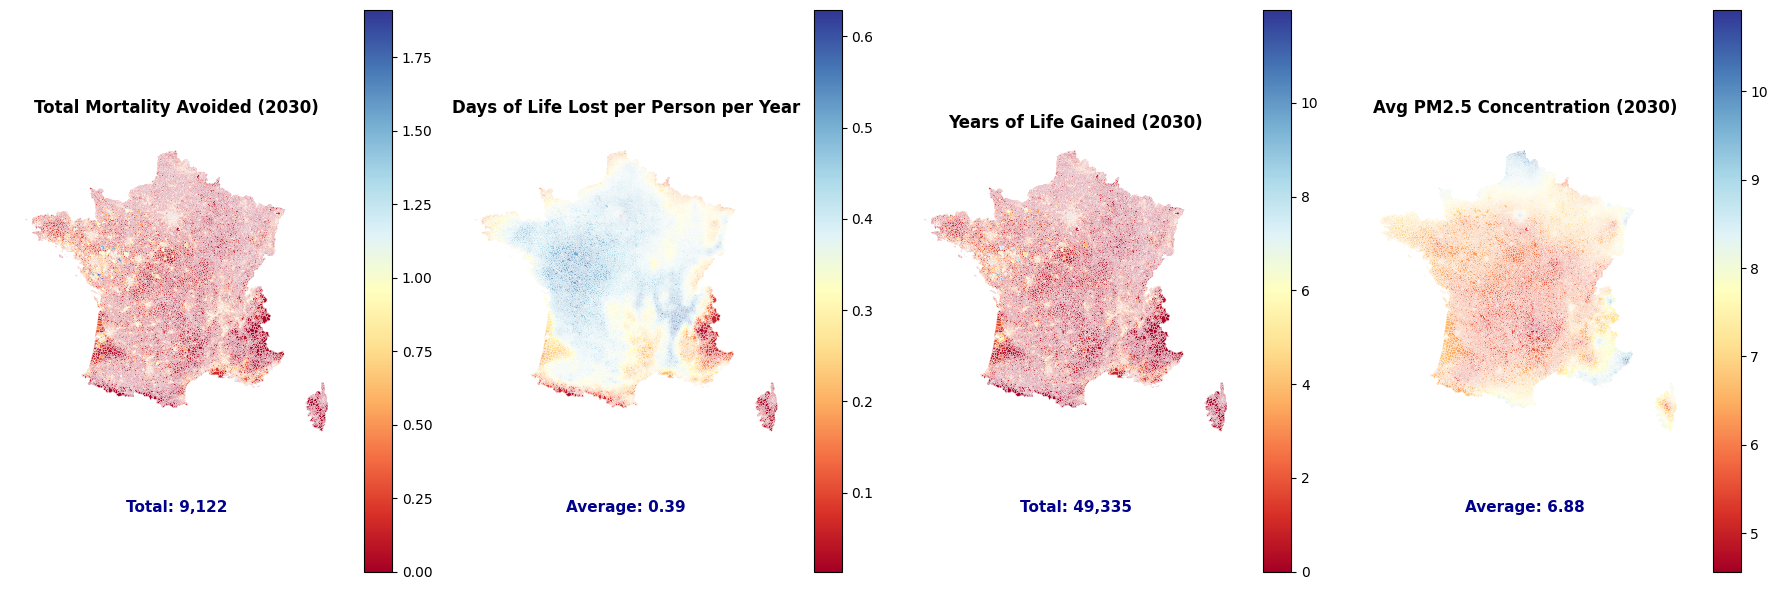

In [6]:
# Step 3: Plot the results with continuous maps and appropriate sum/mean annotations
def plot_multiple_iris_maps(
    iris_level_results, iris_shapefile, columns_to_plot, titles=None, cmap="OrRd", base_path="data/2-output-data"
):
    """
    Plot multiple choropleth maps of IRIS-level mortality results side by side and save as PNG.
    Parameters:
    - iris_level_results: DataFrame returned by calculate_iris_level_mortality()
    - iris_shapefile: GeoDataFrame with 'iriscod' and 'geometry'
    - columns_to_plot: List of columns to visualize
    - titles: List of titles for the plots
    - cmap: Colormap for all plots
    - base_path: Path where the plot will be saved
    """
    # Merge result with shapefile
    plot_data = iris_shapefile.merge(iris_level_results, on="iriscod", how="left")

    n_maps = len(columns_to_plot)
    fig, axes = plt.subplots(1, n_maps, figsize=(18, 6))  # Adjusted figure size for better layout

    if titles is None:
        titles = columns_to_plot

    for i, column in enumerate(columns_to_plot):
        # Check if the column contains numeric values
        if pd.api.types.is_numeric_dtype(plot_data[column]):
            # Plot the data for the given column
            plot_data.plot(
                column=column,
                cmap=cmap,  # Use provided colormap
                linewidth=0.2,  # Finer line width for boundaries
                edgecolor="white",  # Boundary color for areas
                legend=True,
                ax=axes[i],
                vmin=plot_data[column].min(),  # Continuous scale minimum value
                vmax=plot_data[column].max(),  # Continuous scale maximum value
            )

            # Define the annotation value (sum or mean)
            if column.startswith("total") or column.startswith("sum"):
                annotation_value = plot_data[column].sum()
                annotation_label = "Total"
                annotation_text = f"{annotation_label}: {annotation_value:,.0f}"  # 0 decimal places
            else:
                annotation_value = plot_data[column].mean()
                annotation_label = "Average"
                annotation_text = f"{annotation_label}: {annotation_value:,.2f}"  # 2 decimal places

            # Set title and annotation for the map
            axes[i].set_title(titles[i], fontsize=12, fontweight="bold")  # Updated title styling

            # Add annotation for each map
            axes[i].text(
                0.5, -0.2,  # Adjusted position to avoid overlap (below the map)
                annotation_text,
                transform=axes[i].transAxes,
                ha="center", va="center", fontsize=11, fontweight="bold", color="darkblue"  # Styling and alignment
            )
            axes[i].axis("off")  # Turn off axes for clarity
        else:
            axes[i].set_title(f"{titles[i]} (Non-numeric data)", fontsize=14, fontweight="bold")
            axes[i].axis("off")  # Hide the map if data is non-numeric

    plt.tight_layout()

    # Save the plot as PNG
    output_path = os.path.join(base_path, "iris_mortality_maps_continuous.png")
    plt.savefig(output_path, dpi=300)
    plt.show()

# Call plotting function
plot_multiple_iris_maps(
    iris_level_results=results,
    iris_shapefile=iris_shapefile,
    columns_to_plot=["total_mortality_avoided", "dll_per_person_per_year", "total_years_gained", "mean_concentration"],
    titles=["Total Mortality Avoided (2030)", "Days of Life Lost per Person per Year", "Years of Life Gained (2030)", "Avg PM2.5 Concentration (2030)"],
    cmap="RdYlBu"
)